In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(last_level=4)

## Background
A building permit is an official approval document issued by a governmental agency that allows you or your contractor to proceed with a construction or remodeling project on one's property. For more details go to https://www.thespruce.com/what-is-a-building-permit-1398344. Each city or county has its own office related to buildings, that can do multiple functions like issuing permits, inspecting buildings to enforce safety measures, modifying rules to accommodate needs of the growing population etc. For the city of San Francisco, permit issuing is taken care by www.sfdbi.org/

Why is this important: In the recent past, several posts and blogs highlighted that main discrepancy in demand and supply in real estate industry is due to delays in issuing building permits. Refer: https://www.trulia.com/blog/trends/elasticity-2016/ - Introduces concept of elasticity, and nice scatterplot of various cities. A good data story! https://biv.com/article/2014/11/city-building-permit-delays-costing-developers-tim

## Content
The data was downloaded for the dates ranging from Jan 1st, 2013 to Feb 25th, 2018 using the filter in San Francisco open data portal. This is the exact link: https://data.sfgov.org/Housing-and-Buildings/Building-Permits/i98e-djp9/data There are 43 columns and close to 200k records in the downloaded version (kept here). Description is separately uploaded as dictionary.

## Target
Predict number of days to wait for the permit, counted from filed date to issued date

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pd.options.display.max_columns = 99

## 1. Data

In [5]:
permit = pd.read_csv('Building_Permits.csv', index_col='Record ID')

/home/hung/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
permit.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location
Record ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1380611233945,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,NaN,NaN,"ground fl facade: to erect illuminated, electr...",expired,12/21/2017,05/06/2015,11/09/2015,NaN,11/09/2015,NaN,6.0,NaN,NaN,NaN,11/03/2016,4000.0,4000.0,tourist hotel/motel,143.0,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)"
1420164406718,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,NaN,remove (e) awning and associated signs.,issued,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,NaN,7.0,NaN,NaN,NaN,12/03/2017,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)"
1424856504716,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,NaN,NaN,installation of separating wall,withdrawn,09/26/2017,05/27/2016,NaN,NaN,NaN,NaN,6.0,6.0,NaN,NaN,NaN,20000.0,NaN,retail sales,39.0,retail sales,39.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)"
1443574295566,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,NaN,repair dryrot & stucco at front of bldg.,complete,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,NaN,2.0,2.0,NaN,NaN,07/13/2018,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)"
144548169992,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,NaN,demolish retail/office/commercial 3-story buil...,issued,12/01/2017,11/28/2016,12/01/2017,NaN,11/20/2017,NaN,3.0,NaN,NaN,NaN,12/01/2018,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)"


### 1.1. Data overview

In [7]:
print ("Rows     : ", permit.shape[0])
print ("Columns  : ", permit.shape[1])
print ('=' * 50, "\nFeatures :\n", permit.columns.tolist())
print ('=' * 50, "\nMissing values:", permit.isnull().sum().values.sum())

# Unique values
uni = permit.nunique()
print ('=' * 50, "\nUnique values:\n", uni)

Rows     :  198900
Columns  :  42
Features :
 ['Permit Number', 'Permit Type', 'Permit Type Definition', 'Permit Creation Date', 'Block', 'Lot', 'Street Number', 'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit', 'Unit Suffix', 'Description', 'Current Status', 'Current Status Date', 'Filed Date', 'Issued Date', 'Completed Date', 'First Construction Document Date', 'Structural Notification', 'Number of Existing Stories', 'Number of Proposed Stories', 'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Permit Expiration Date', 'Estimated Cost', 'Revised Cost', 'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units', 'Plansets', 'TIDF Compliance', 'Existing Construction Type', 'Existing Construction Type Description', 'Proposed Construction Type', 'Proposed Construction Type Description', 'Site Permit', 'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode', 'Location']
Missing values: 2245941
Unique values:
 Permit Number                        

In [8]:
print('Unique value count for each feature\n')
for col in permit.columns:
    print('='*50)
    if uni[col] < 10:
        print(permit[col].value_counts())
    else:
        print('Name: {} has many values to display: {}'.format(col, uni[col]))

Unique value count for each feature

Name: Permit Number has many values to display: 181495
8    178844
3     14663
4      2892
2       950
6       600
7       511
1       349
5        91
Name: Permit Type, dtype: int64
otc alterations permit                 178844
additions alterations or repairs        14663
sign - erect                             2892
new construction wood frame               950
demolitions                               600
wall or painted sign                      511
new construction                          349
grade or quarry or fill or excavate        91
Name: Permit Type Definition, dtype: int64
Name: Permit Creation Date has many values to display: 1291
Name: Block has many values to display: 4896
Name: Lot has many values to display: 1055
Name: Street Number has many values to display: 5099
Name: Street Number Suffix has many values to display: 18
Name: Street Name has many values to display: 1704
Name: Street Suffix has many values to display: 21
Name: Un

**Data initial info**

In [9]:
# load column description
# Please edit DataDictionaryBuildingPermit.xlsx file before run this cell
# Besure there's no enter '\n' in each cell
# Street Number Suffix not Street Suffix
# Unit Suffix not Unit suffix
col_des = pd.read_excel('DataDictionaryBuildingPermit.xlsx', index_col='Column name').drop('Sl No', axis=1)

with open('permit_info.txt', 'wt') as ff:
    permit.info(buf=ff)
    
row_name = []
n_non_nul = []
dtype = []
with open('permit_info.txt', 'rt') as ff:
    for line in ff.readlines()[3:-2]:
        row_name.append(line[0:40].strip())
        n_non_nul.append(int(line[40:line.find(' non')]))
        dtype.append(line[line.rfind(' ')+1:-1])
nndf = pd.DataFrame({'Column name': row_name, 'non-null number': n_non_nul, 'dtype': dtype})\
         .set_index('Column name')
col_des['non-null number'] = nndf['non-null number']
col_des['dtype'] = nndf['dtype']
col_des['unique number'] = uni
col_des

,Description,non-null number,dtype,unique number
Column name,,,,
Permit Number,Number assigned while filing,198900.0,object,181495.0
Permit Type,Type of the permit represented numerically.,198900.0,int64,8.0
Permit Type Definition,"Description of the Permit type, for example n...",198900.0,object,8.0
Permit Creation Date,"Date on which permit created, later than or sa...",198900.0,object,1291.0
Block,Related to address,198900.0,object,4896.0
Lot,Related to address,198900.0,object,1055.0
Street Number,Related to address,198900.0,int64,5099.0
Street Number Suffix,Related to address,2216.0,object,18.0
Street Name,Related to address,198900.0,object,1704.0


Based on type, number of notnull elements, unique number we will use following columns as features

In [10]:
select_columns = ['Permit Type',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Unit',      
       'Filed Date', 'Issued Date', 
       'First Construction Document Date', 'Structural Notification',
       'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Estimated Cost', 'Revised Cost',
       'Proposed Units',
       'Plansets',
       'Proposed Construction Type',
       'Site Permit',
       'Supervisor District', 'Zipcode',
       'Location']

cat_cols = ['Permit Type', 'Plansets', 'Proposed Construction Type', 'Supervisor District']
bin_cols = ['Structural Notification', 'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Site Permit']
date_col = ['Permit Creation Date', 'Filed Date', 'Issued Date', 'First Construction Document Date']

### 1.2 Data preprocessing

#### Drop unused columns

In [11]:
permit = permit[select_columns]

#### Drop all rows without Issued Date information

In [12]:
permit = permit[permit['Issued Date'].notnull()]

#### Transform date columns to date type

In [13]:
# this will take several time
for column in date_col:
    permit[column] = pd.to_datetime(permit[column])

#### Transform binary columns

In [14]:
for column in bin_cols:
    permit[column] = permit[column].notnull().astype('int')

#### Calculate waited time

In [15]:
permit['waited time'] = permit['Issued Date'] - permit['Filed Date']
permit['waited time'] = permit['waited time'].apply(lambda dt: dt.days)

#### Calculate preparated time

In [16]:
permit['preparated time'] = permit['First Construction Document Date'] - permit['Filed Date']
permit['preparated time'] = permit['preparated time'].apply(lambda dt: dt.days)

#### Calculate Filed Date to a specific date

In [17]:
permit['moment'] = pd.to_datetime('2020/01/01') - permit['Filed Date']
permit['moment'] = permit['moment'].apply(lambda dt: dt.days)

#### Waited time distribution

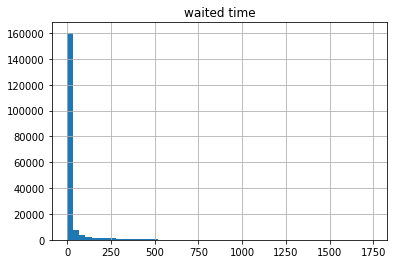

In [18]:
permit.hist(column='waited time', bins=50)
plt.show()

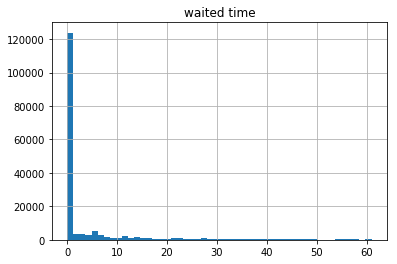

In [19]:
# for waited time <= 2 months
permit[permit['waited time']<62].hist(column='waited time', bins=50)
plt.show()

#### some distribution based on categorical columns

In [20]:
# change planset 9000 to 7
permit.Plansets = permit.Plansets.apply(lambda x: min(x, 7))

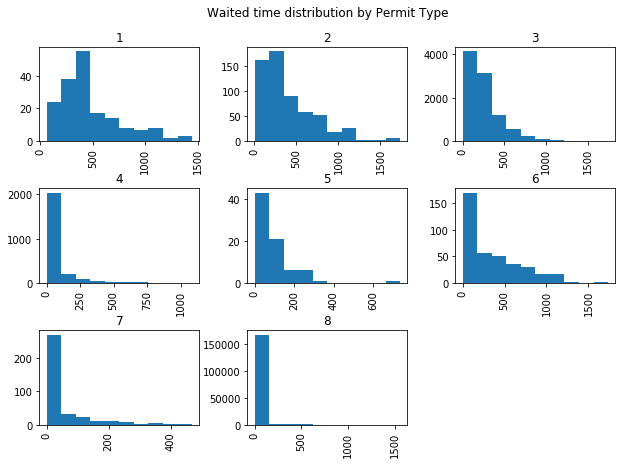

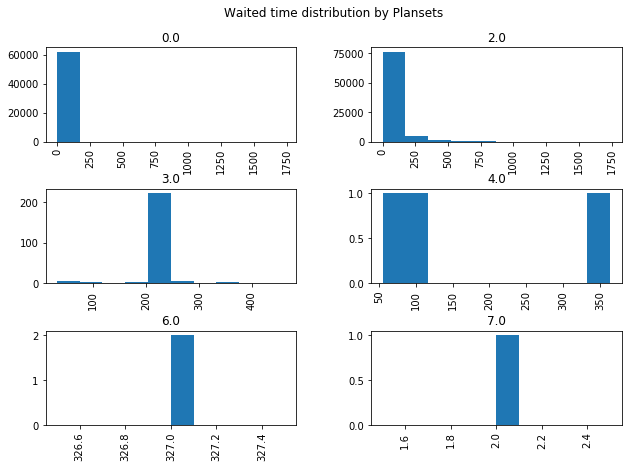

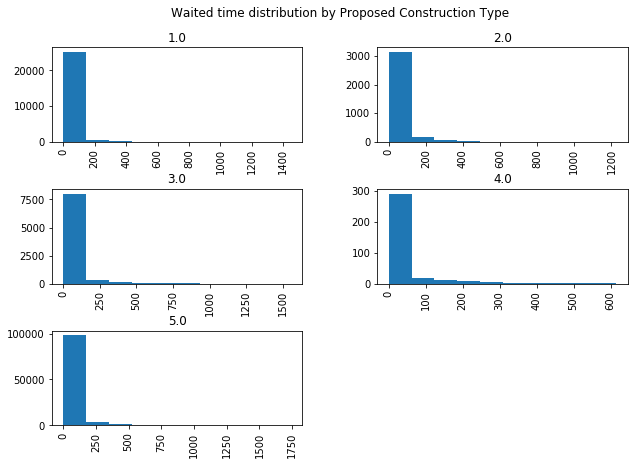

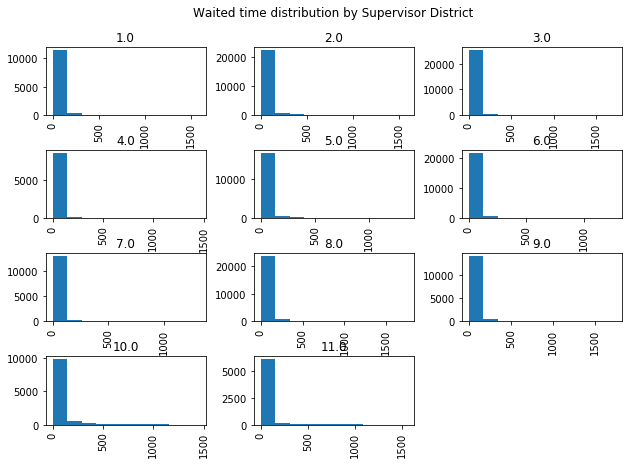

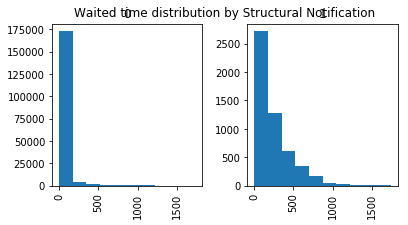

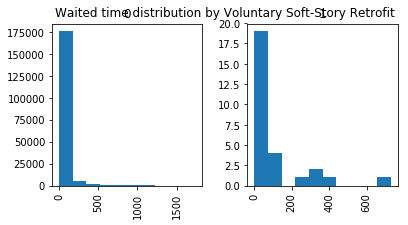

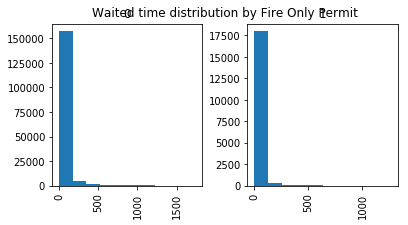

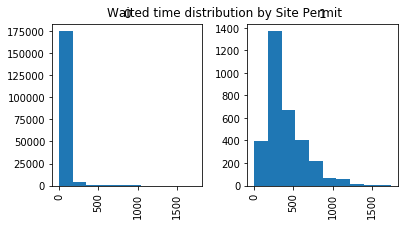

In [21]:
for column in cat_cols:
    permit.hist(column='waited time', by=column, figsize=(10,7))
    plt.suptitle('Waited time distribution by ' + column)
    plt.show()
for column in bin_cols:
    permit.hist(column='waited time', by=column, figsize=(6,3))
    plt.suptitle('Waited time distribution by ' + column)
    plt.show()

In [22]:
# see what is what in Permit type
pd.read_csv('Building_Permits.csv')[['Permit Type', 'Permit Type Definition']].drop_duplicates().sort_values('Permit Type')

/home/hung/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Permit Type,Permit Type Definition
83,1,new construction
164,2,new construction wood frame
2,3,additions alterations or repairs
0,4,sign - erect
152,5,grade or quarry or fill or excavate
4,6,demolitions
55,7,wall or painted sign
3,8,otc alterations permit


#### force to numeric

In [23]:
permit.Block = permit.Block.apply(lambda x: int(''.join((filter(str.isdigit, x)))))

In [24]:
permit.Lot = permit.Lot.apply(lambda x: int(''.join((filter(str.isdigit, x)))))

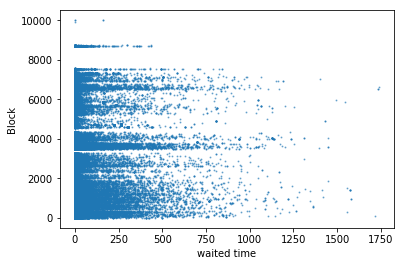

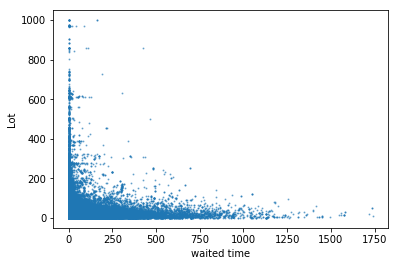

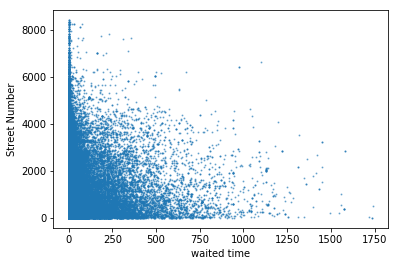

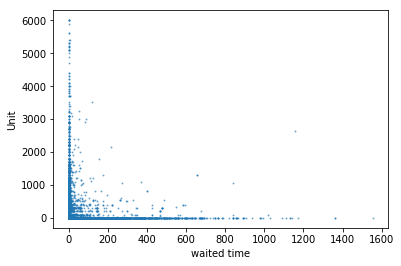

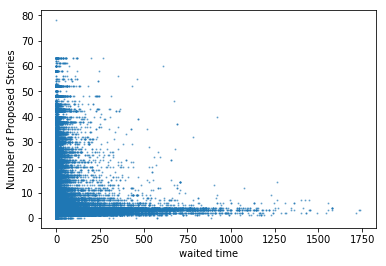

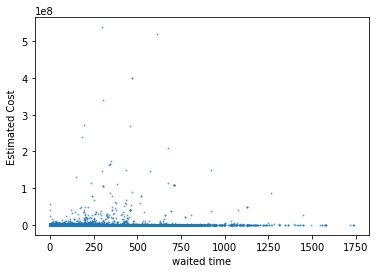

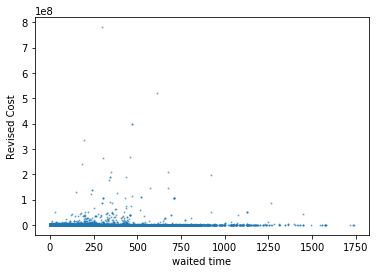

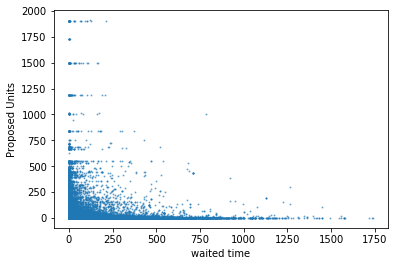

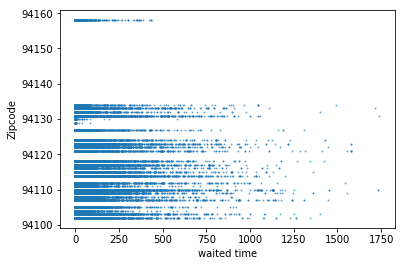

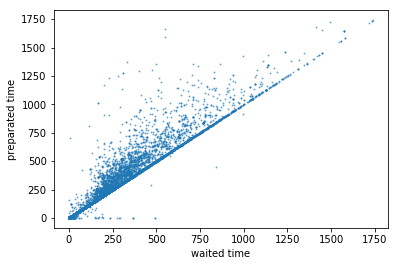

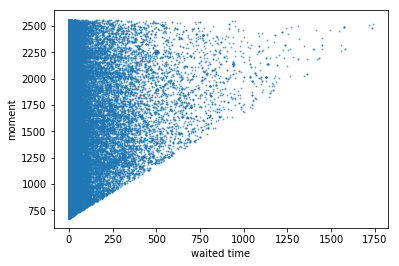

In [25]:
target_col = ['waited time']
loc_col = ['Location']
num_col = [col for col in permit.columns if col not in bin_cols+cat_cols+date_col+target_col+loc_col]
for column in num_col:
    permit.plot.scatter(x='waited time', y=column, s=1, alpha=0.5)

#### fill missing value

In [26]:
permit.Unit.fillna(permit.Unit.mode()[0], inplace=True)
permit['Number of Proposed Stories'].fillna(permit['Number of Proposed Stories'].mode()[0], inplace=True)
permit['Estimated Cost'].fillna(permit['Estimated Cost'].median(), inplace=True)
permit['Revised Cost'].fillna(permit['Revised Cost'].median(), inplace=True)
permit['Proposed Units'].fillna(permit['Proposed Units'].mode()[0], inplace=True)
permit['Plansets'].fillna(permit['Plansets'].mode()[0], inplace=True)
permit['Proposed Construction Type'].fillna(permit['Proposed Construction Type'].mode()[0], inplace=True)
permit['Supervisor District'].fillna(permit['Supervisor District'].mode()[0], inplace=True)
permit['Zipcode'].fillna(permit['Zipcode'].mode()[0], inplace=True)
permit['Location'].fillna(permit['Location'].mode()[0], inplace=True)
permit['preparated time'].fillna(int(permit['preparated time'].median()), inplace=True)

#### calculate latitude, longitude, drop location

In [27]:
# run this cell once!!!
permit['latitude'] = permit.Location.apply(lambda pair: pair.strip('()').split(', ')[0])
permit['latitude'] = permit['latitude'].astype('float')
permit['logitude'] = permit.Location.apply(lambda pair: pair.strip('()').split(', ')[1])
permit['logitude'] = permit['logitude'].astype('float')
permit.drop(columns='Location', inplace=True)

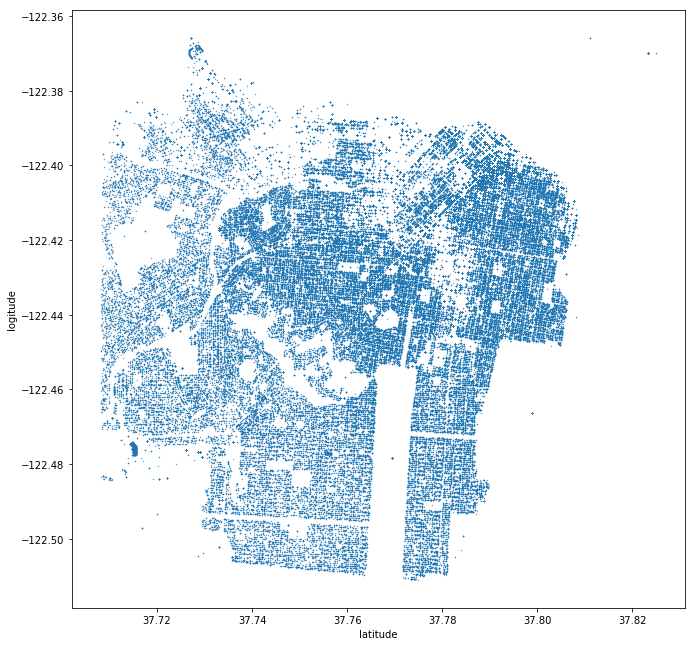

In [28]:
# location distribution
permit.plot.scatter(x='latitude', y='logitude', s=0.1, figsize=(11, 11))
plt.show()

#### map of Sn Francisco
![](https://www.spur.org/sites/default/files/wysiwyg/u194/Muni_map_2015.jpg)

#### Variable summary¶

In [29]:
ana_col = ['Block', 'Lot', 'Street Number', 'Unit', 'Structural Notification', 'Number of Proposed Stories',
 'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Estimated Cost', 'Revised Cost', 'Proposed Units',
 'Site Permit', 'Zipcode', 'preparated time', 'latitude', 'logitude', 'moment']
pd.DataFrame(permit[ana_col].describe())\
  .transpose().reset_index()\
  .rename(columns = {"index" : "feature"})\
  .set_index('feature')

,count,mean,std,min,25%,50%,75%,max
feature,,,,,,,,
Block,183960.0,2649.564579,2.149271e+03,4.000000,777.000000,2129.000000,3738.000000,9.999000e+03
Lot,183960.0,29.452566,4.493485e+01,0.000000,8.000000,19.000000,35.000000,9.990000e+02
Street Number,183960.0,1118.511850,1.133646e+03,0.000000,235.000000,705.000000,1699.000000,8.400000e+03
Unit,183960.0,12.119281,1.319235e+02,0.000000,0.000000,0.000000,0.000000,6.004000e+03
Structural Notification,183960.0,0.028321,1.658898e-01,0.000000,0.000000,0.000000,0.000000,1.000000e+00
Number of Proposed Stories,183960.0,4.986407,7.885690e+00,0.000000,2.000000,2.000000,3.000000,7.800000e+01
Voluntary Soft-Story Retrofit,183960.0,0.000152,1.233631e-02,0.000000,0.000000,0.000000,0.000000,1.000000e+00
Fire Only Permit,183960.0,0.099364,2.991509e-01,0.000000,0.000000,0.000000,0.000000,1.000000e+00
Estimated Cost,183960.0,112445.913751,3.120737e+06,1.000000,5000.000000,10000.000000,23595.000000,5.379586e+08


#### Corelation matrix

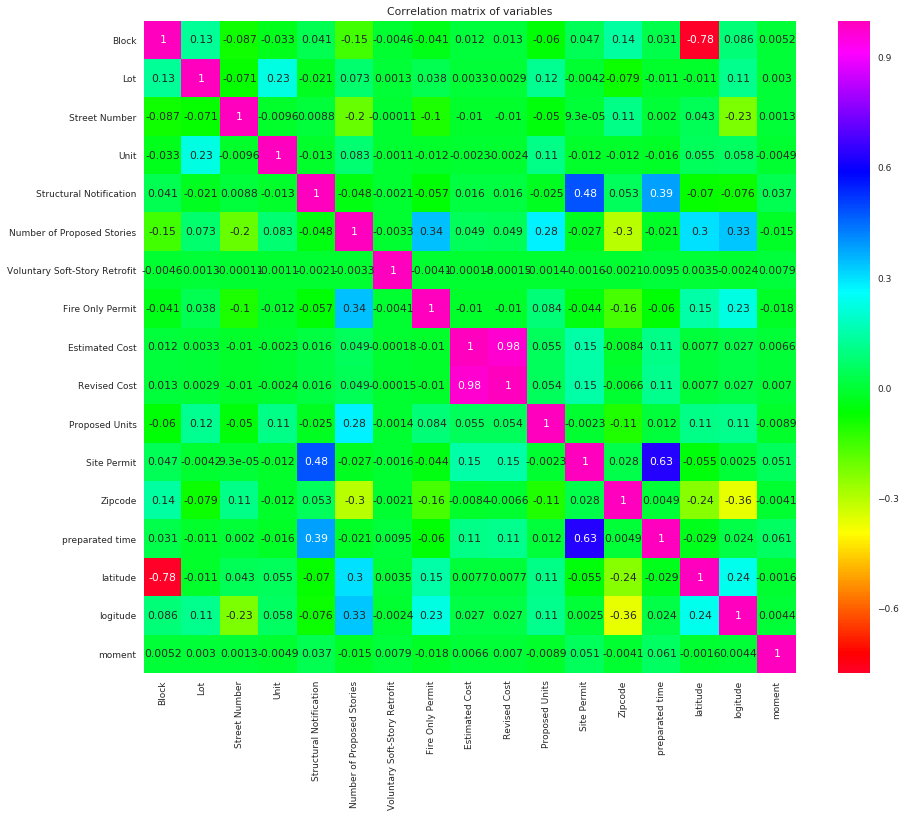

In [30]:
import seaborn as sns
sns.set(font_scale=0.9)
plt.figure(figsize=(15,12))
sns.heatmap(data=permit[ana_col].corr(), xticklabels=True, yticklabels=True, cmap='gist_rainbow', square=True, annot=True)
plt.title('Correlation matrix of variables')
plt.show()

#### Transform categorical columns

In [31]:
# force to integer type
for column in cat_cols:
    permit[column] = permit[column].astype('int')

In [32]:
# run this cell once
permit_b = permit.copy()  # backup for the model without categorical data
permit = pd.get_dummies(permit, columns=cat_cols)

In [33]:
features = [col for col in permit.columns if col not in date_col+target_col]
if 'First Construction Document Date' in features:
    features.remove('First Construction Document Date')

In [34]:
date_col

['Permit Creation Date',
 'Filed Date',
 'Issued Date',
 'First Construction Document Date']

#### check if there's any null

In [35]:
permit[features+target_col].isnull().sum()

Block                            0
Lot                              0
Street Number                    0
Unit                             0
Structural Notification          0
Number of Proposed Stories       0
Voluntary Soft-Story Retrofit    0
Fire Only Permit                 0
Estimated Cost                   0
Revised Cost                     0
Proposed Units                   0
Site Permit                      0
Zipcode                          0
preparated time                  0
moment                           0
latitude                         0
logitude                         0
Permit Type_1                    0
Permit Type_2                    0
Permit Type_3                    0
Permit Type_4                    0
Permit Type_5                    0
Permit Type_6                    0
Permit Type_7                    0
Permit Type_8                    0
Plansets_0                       0
Plansets_2                       0
Plansets_3                       0
Plansets_4          

## 2. Build and train model 

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Normally we will split into train & test sets by the following line, where `features` include all columns in dataframe that we consider as feature, and `target_col` is the column that we have to build a predictor.

In [37]:
train_X, test_X, train_y, test_y = \
train_test_split(permit[features], permit[target_col], test_size = .2 ,random_state = 42)

In [38]:
# read IDs
trainID = pd.read_csv('Permit_train_RecordID.csv', index_col='Record ID')
testID = pd.read_csv('Permit_test_RecordID.csv', index_col='Record ID')

# split into train/test
train = permit.merge(trainID, left_index=True, right_index=True)
train_X = train[features]
train_y = train[target_col]

test = permit.merge(testID, left_index=True, right_index=True)
test_X = test[features]
test_y = test[target_col]

In [39]:
# train model
lr = LinearRegression(normalize=True)
lr.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

## 3. Model evaluation

In [40]:
# get prediction
pred = lr.predict(test_X)

In [41]:
# RMSE
rmse = np.sqrt(mean_squared_error(test_y, pred))
print('RMSE:', rmse)

RMSE: 15.62555807039974


In [42]:
rmse/permit['waited time'].mean()

0.5997213579722221

In [43]:
rmse/permit['waited time'].max()

0.008980205787586057

In [44]:
permit[permit['waited time']==0].shape[0]

115488

In [45]:
# bias coefficient
lr.intercept_

array([-1.43951762e+13])

In [46]:
# weights
pd.DataFrame({'feature': features, 'coefficient': lr.coef_[0]})

,feature,coefficient
0,Block,1.458333e-04
1,Lot,-2.710859e-03
2,Street Number,1.252653e-05
3,Unit,2.648552e-05
4,Structural Notification,1.887158e+00
5,Number of Proposed Stories,2.281259e-03
6,Voluntary Soft-Story Retrofit,-2.798215e+00
7,Fire Only Permit,-1.265726e+00
8,Estimated Cost,2.538045e-07
9,Revised Cost,-2.201936e-07


In [47]:
# what if no categorical? or consider categorical as number
features2 = [col for col in permit_b.columns if col not in date_col+target_col]

# train_X2, test_X2, train_y2, test_y2 = \
# train_test_split(permit_b[features2], permit_b[target_col], test_size = .2 ,random_state = 42)

train2 = permit_b.merge(trainID, left_index=True, right_index=True)
train_X2 = train2[features2]
train_y2 = train2[target_col]

test2 = permit_b.merge(testID, left_index=True, right_index=True)
test_X2 = test2[features2]
test_y2 = test2[target_col]



lr2 = LinearRegression(normalize=True)
lr2.fit(train_X2, train_y2)

pred2 = lr2.predict(test_X2)

In [48]:
rmse2 = np.sqrt(mean_squared_error(test_y2, pred2))
print('RMSE:', rmse2)

RMSE: 15.736953235071981


In [49]:
# bias coefficient
lr2.intercept_

array([-1110.58071677])

In [50]:
# weights
dff = pd.DataFrame({'feature': features2, 'coefficient': lr2.coef_[0]}).set_index('feature')
dff['max value'] = permit_b[features2].max()
dff['coef x max'] = dff.coefficient * dff['max value']
dff

,coefficient,max value,coef x max
feature,,,
Permit Type,-1.681733e+00,8.000000e+00,-13.453862
Block,1.142431e-04,9.999000e+03,1.142316
Lot,-4.483511e-03,9.990000e+02,-4.479027
Street Number,3.313497e-05,8.400000e+03,0.278334
Unit,1.106322e-04,6.004000e+03,0.664236
Structural Notification,3.823366e+00,1.000000e+00,3.823366
Number of Proposed Stories,-1.129745e-02,7.800000e+01,-0.881201
Voluntary Soft-Story Retrofit,-1.315656e+00,1.000000e+00,-1.315656
Fire Only Permit,-1.037516e+00,1.000000e+00,-1.037516


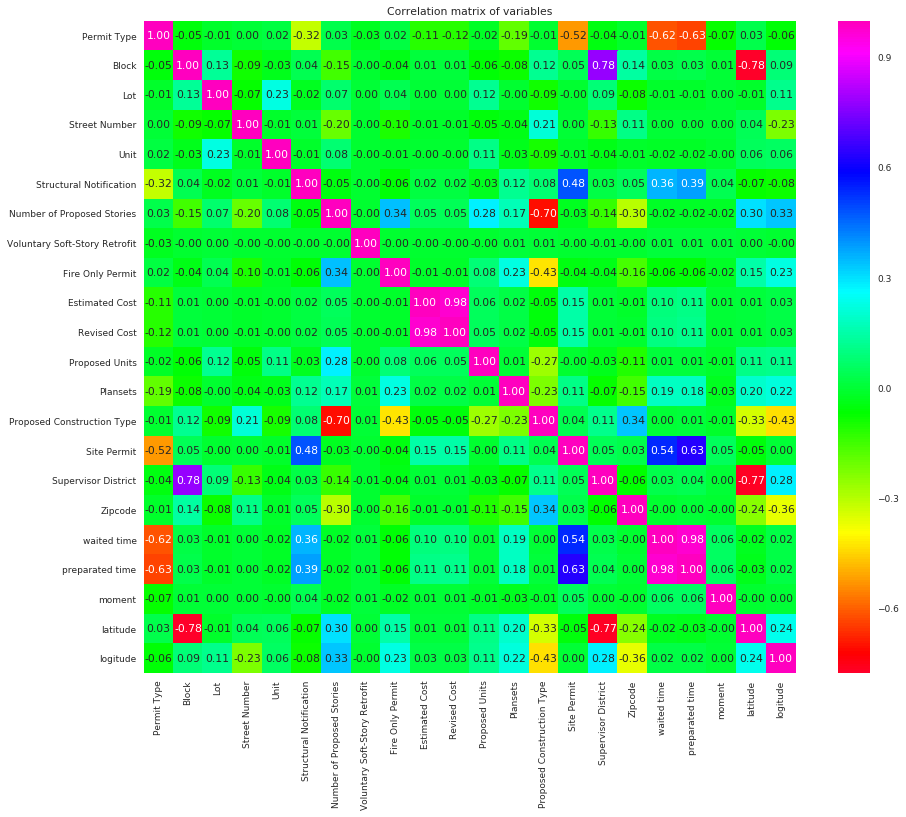

In [55]:
sns.set(font_scale=0.9)
plt.figure(figsize=(15,12))
sns.heatmap(data=permit_b.corr(), xticklabels=True, yticklabels=True, 
            cmap='gist_rainbow', square=True, annot=True, fmt='.2f')
plt.title('Correlation matrix of variables')
plt.show()